In [41]:
# !pip install --upgrade jaxlib
# !pip install jax==0.4.3
# !pip install jax-numpy-polynomial
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt


# Problem Definition

**Anti-derivative Operator**

Consider the ordinary differential equation (ODE) given by:

$$\frac{ds(x)}{dx}-u(x)=0$$

The solution of our ODE is:

$$G:f(x)→s(x)=s(0)+\int_{0}^{x}f(t)dt$$

$$x\in[0,1]$$
$$s(0)=0$$

# Auxilliary Functions 

**Sample_Polynomial()**

Generates a sample of a polynomial defined as a linear combination of the basis functions ${1, x, x^2, ..., x^d}$, where $d$ is the degree of the polynomial.

**Args:** 

*   **degree**, the degree of the polynomial; 
*   **num_samples**, the number of samples to be generated;
*   **key**, a random seed for generating the coefficients of the polynomial;  
* **domain_min** and **domain_max**, the minimum and maximum values of the domain respectively.

**Output:** An array of size (num_samples * 2), where each row is a sample (x, y).

The polynomial sampling function generates a polynomial of degree degree with randomly sampled coefficients $c_i$. The coefficients are sampled from a uniform distribution over the interval $[-10, 10]$, so we can write:

$$c_i \sim \mathcal{U}(-10, 10),$$

and the polynomial can be expressed as:

$$p(x) = \sum_{i=0}^{d} c_i x^i$$

where d is the degree of the polynomial and c_i are the coefficients.


In [60]:
def sample_polynomial(degree, m, key, domain_min=0, domain_max=1):
    x_values = onp.linspace(domain_min, domain_max, m)
    coefficients = random.uniform(key, shape=(degree + 1,), minval=-10, maxval=10)
    y_values = np.polyval(coefficients, x_values)
    samples = np.column_stack((x_values, y_values))
    return samples


In [61]:
def plot_us(x,u,y,s):
  fig, ax1 = plt.subplots(figsize=(8, 6))
  plt.rcParams['font.size'] = '18'
  color='black'
  wdt=1.5
  ax1.plot(x,u,'k--',label='$u(x)=ds/dx$',linewidth=wdt)
  ax1.plot(y,s,'o-',label='$s(x)=s(0)+\int u(t)dt|_{t=y}$',linewidth=wdt)
  ax1.set_xlabel('x',fontsize='large')
  ax1.set_ylabel('u',fontsize='large')
  ax1.tick_params(axis='y', color=color)
  ax1.legend(loc = 'lower right', ncol=1)
  

# Initialization of Variables

In [73]:
degree = 50
domain_min = 0
domain_max = 1
N_train = 2 # overridden in data gen
P_train = 5 # overridden in data gen
m = 100 # number of input sensors
x = np.linspace(0, 1, m)
key = random.PRNGKey(0)  # use different key for generating training data and test data 
config.update("jax_enable_x64", True) # Enable double precision

# Demonstration of odeint() Generating a Single Training Data

$u_{fn}$: A callable polynomial function that uses np.polyval() to recreate the polynomial sample and evaluate it at the points in 't'.

$u$: evaluates the $u_{fn}$ function at $x$ and assign result to $u$

**Note**: In this code block, the grid for sampling the polynomial input is determined by np.linspace(0, 1, N), while the grid for evaluating the solution of the ODE is determined by y_train which is obtained by np.take(y_train, sorted_indices).

The polynomial coefficients, given in descending order of power, are:  [ 9.30642922 -5.4968192 ]


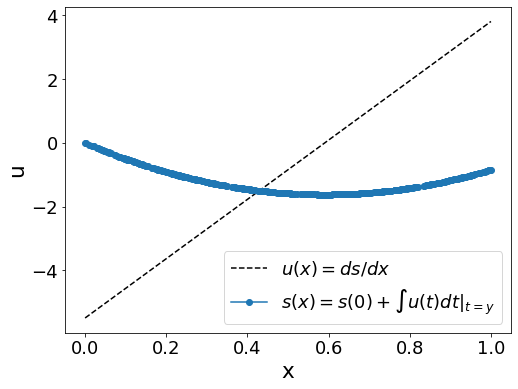

In [54]:
# Sample polynomial at `m` sensor points on [0,1]
samples = sample_polynomial(degree, m, key)
coeffs = np.polyfit(samples[:, 0], samples[:, 1], degree)

# Input sensor locations and measurements
u = samples[:,1]

# Create a callable interpolation function 
u_fn = lambda x, t: np.polyval(coeffs, t)

# Output sensor locations and measurements
y_train = random.uniform(key=key, shape=(P_train*100,)).sort()
s_train = odeint(u_fn, 0.0, y_train) 

plot_us(x,u,y_train,s_train)

print('The polynomial coefficients, given in descending order of power, are: ', coeffs)


# Generating Training and Test Data (Functions)

**DeepOnet**

Learn the solution operators of ODE → We will try to approximate ${\cal G}$  (the solution of our ODE operator) by two neural networks:


$$G_\theta(u)(y)=\sum_{k=1}^q\underset{Branch}{\underbrace{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}}.\underset{Trunk}{\underbrace{t_k(\textbf{y})}}$$


We want to obtain G, so our goal would be:

 $$\tilde{{\cal G}}_(u)(y)\approx G(u)(y)$$

So we will enforce that condition into a loss function:

$$
\hat{\cal L}(\theta) = \frac{1}{NP}\sum_{i=1}^S\sum_{j=1}^P\left|\int_{0}^{y_j}u_i(t)dt -\tilde{\cal G}(\mathbf u_i)\Big{|}_{y_j}\right|^2
$$

$$
\hat{\cal L}(\theta) = \frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|\int_{0}^{y_j}u_i(t)dt -\sum_{k=1}^q{\cal N}_{\mathrm{B,k}}(u_i(x_1),u_i(x_2),\dots,u_i(x_m))\cdot{\cal N}_{\mathrm{T,k}}(y_j)\right|^2.
$$

**Parameters** \\
𝑚 = Number of input sensors

$N = N_{train}$ = Number of input functions $𝑢_i(𝑥)$ in our training data

$P = 𝑃_{train}$:  Number of collocation points $(y_j)_{j=1}^P$

$P_{test}$:  Number of points at which we evaluate the antiderivative $\tilde{\cal 𝐺}(𝑢)$ of the test sample u

$\underset{N_{train} \ sets \ generated}{\underbrace{(u_{train}\in R^{P \ \times \ m}, y_{train}\in R^P, s_{train}\in R^P)}}$

$\underset{N_{test}=1 \ set \ generated}{\underbrace{u_{test}\in R^{P_{test} \ \times \ m}, y_{test}\in R^{P_{test}}, s_{test}\in R^{P_{test}}}}$

**Note:** both the function $u_i(t)$ and the integral $\int_{0}^{y_j}u_i(t)dt$ and the function are sampled/evaluated over the domain [0,1].

In [63]:
# Geneate TRAINING data corresponding to one input sample
def generate_one_training_data(degree, key, m, P):
  # Sample polynomial at `m` sensors
  samples = sample_polynomial(degree, m, key)
  coeffs = np.polyfit(samples[:, 0], samples[:, 1], degree)

  # Create a callable interpolation function 
  u_fn = lambda x, t: np.polyval(coeffs, t)

  # Input sensor locations and measurements
  u = samples[:,1]

  # Output sensor locations and measurements
  y_train = random.uniform(key=key, shape=(P,)).sort()
  s_train = odeint(u_fn, 0.0, np.hstack((0.0, y_train)))[1:] #JAX has a bug and always returns s(0), so we add a dummy entry to y and return s[1:]

  # Tile inputs
  u_train = np.tile(u, (P,1))

  return u_train, y_train, s_train


In [64]:
# Generate TEST data corresponding to one input sample
def generate_one_test_data(degree, domain_min, domain_max, key, m, P):
  # Sample polynomial at `m` sensors
  samples = sample_polynomial(degree, m, key)
  coeffs = np.polyfit(samples[:, 0], samples[:, 1], degree)

  # Create a callable interpolation function 
  u_fn = lambda x, t: np.polyval(coeffs, t)

  # Input sensor locations and measurements
  u = samples[:,1]

  # Output sensor locations and measurements
  y = np.linspace(domain_min, domain_max, P)
  s = odeint(u_fn, 0.0, y)

  # Tile inputs
  u = np.tile(u, (P,1))
  
  return u, y, s


# Generate Data 

In [69]:
# Training Data 
N_train = 10 # number of input functions
P_train = 50   # number of collocation points
config.update("jax_enable_x64", True) # Enable double precision
key_train = random.PRNGKey(0)  # use different keys for generating training data and test data 
keys = random.split(key_train, N_train) # Obtain 10000 random numbers
     
gen_fn = jit(lambda key: generate_one_training_data(degree, key, m, P_train)) 
u_train, y_train, s_train = vmap(gen_fn)(keys)

# # DEBUG
# for i in range(len(y_train)):
#     print("u_train[", i, "]: ", u_train[i])
# for i in range(len(y_train)):
#   print("y_train[", i, "]: ", y_train[i])
# for i in range(len(y_train)):
#   print("s_train[", i, "]: ", s_train[i]) 

#Reshape the data
u_train = np.float32(u_train.reshape(N_train * P_train,-1))
y_train = np.float32(y_train.reshape(N_train * P_train,-1))
s_train = np.float32(s_train.reshape(N_train * P_train,-1))

In [ ]:
# Testing Data
N_test = 1 # number of input samples 
P_test = 100 # number of test 'collocation' points 
key_test = random.PRNGKey(12345) # a different key 
     
keys = random.split(key_test, N_test)
gen_fn = jit(lambda key: generate_one_test_data(degree, domain_min, domain_max, key, m, P_test))
u, y, s = vmap(gen_fn)(keys)

uflat1 = u[0,:]
uflat2 = uflat1[0,:]
print('TEST polynomial coefficients, given in descending order of power, are: ', np.polyfit(x, uflat2, degree))

# # # DEBUG
# for i in range(len(y)):
#     print("u[", i, "]: ", u[i])
# for i in range(len(y)):
#   print("y[", i, "]: ", y[i])
# for i in range(len(y)):
#   print("s[", i, "]: ", s[i])

#Reshape the data
u_test = np.float32(u.reshape(N_test * P_test,-1))
y_test = np.float32(y.reshape(N_test * P_test,-1))
s_test = np.float32(s.reshape(N_test * P_test,-1))

In [75]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample
        self.y = y # location
        self.s = s # labeled data evulated at y (solution measurements)
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

# DeepONet 

In [24]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply
     

In [25]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=relu)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=relu)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=1000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()
        # Logger
        self.loss_log = []

    # Define opeartor net
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return outputs
      
    # Define ODE/PDE residual
    def residual_net(self, params, u, y):
        s_y = grad(self.operator_net, argnums = 2)(params, u, y)
        return s_y

    # Define loss
    def loss(self, params, batch):
        # Fetch data
        # inputs: (u, y), shape = (N, m), (N,1)
        # outputs: s, shape = (N,1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        # print("params:", params)
        pred = vmap(self.operator_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        # print("Inputs:", inputs)
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute loss
                loss_value = self.loss(params, batch)

                # Store loss
                self.loss_log.append(loss_value)

                # Print loss during training
                pbar.set_postfix({'Loss': loss_value})
       
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_s_y(self, params, U_star, Y_star):
        s_y_pred = vmap(self.residual_net, (None, 0, 0))(params, U_star, Y_star)
        return s_y_pred

# Evaluate operator

In [76]:
# Initialize model
# For vanilla DeepONet, shallower network yields better accuarcy.
branch_layers = [100, 100, 100] 
trunk_layers =  [1, 100, 100]

model = DeepONet(branch_layers, trunk_layers)

# Create data set
batch_size = 10
dataset = DataGenerator(u_train, y_train, s_train, batch_size)

# Train
model.train(dataset, nIter=1000)

# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)[:,None]  
s_y_pred = model.predict_s_y(params, u_test, y_test) # remember that s_y=ds/dy=u
    
# Compute relative l2 error
error_s = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 
error_u = np.linalg.norm(u_test[::P_test].flatten()[:,None] - s_y_pred) / np.linalg.norm(u_test[::P_test].flatten()[:,None])  

print('Solution Error: ', error_s, 'Input Error: ', error_u)


100%|██████████| 1000/1000 [00:01<00:00, 741.72it/s, Loss=0.0027221436038608634]


Solution Error:  0.024373575149697204 Input Error:  0.087407656


# Visualise the results for the first function in our Testing Dataset

error_u: 2.437e-02


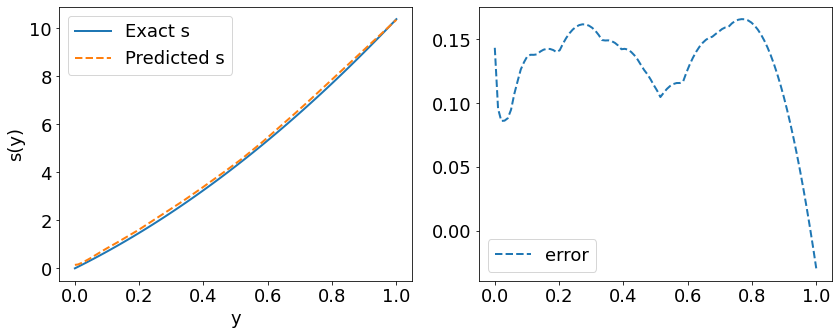

In [77]:
idx=0
index = np.arange(idx * P_test,(idx + 1) * P_test)
     
# Compute the relative l2 error for one input sample 
error_u = np.linalg.norm(s_test[index, :] - s_pred[index, :], 2) / np.linalg.norm(s_test[index, :], 2) 
error_s = np.linalg.norm(u_test[::P_test][idx].flatten()[:,None] - s_y_pred[index, :], 2) / np.linalg.norm(u_test[::P_test][idx].flatten()[:,None], 2) 

print("error_u: {:.3e}".format(error_u))
# print("error_s: {:.3e}".format(error_s))

# Visualizations
# Predicted solution s(y)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], s_test[index, :], label='Exact s', lw=2)
plt.plot(y_test[index, :], s_pred[index, :], '--', label='Predicted s', lw=2)
plt.xlabel('y')
plt.ylabel('s(y)')
plt.tight_layout()
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], s_pred[index, :] - s_test[index, :], '--', lw=2, label='error')
plt.tight_layout()
plt.legend()
plt.show()

# Predicted residual u(x)
# fig = plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.plot(y_test[index, :], u_test[::P_test][idx], label='Exact u', lw=2)
# plt.plot(y_test[index, :], s_y_pred[index,:], '--', label='Predicted u', lw=2)
# plt.legend()
# plt.tight_layout()

# plt.subplot(1,2,2)
# plt.plot(y_test[index, :], s_y_pred[index,:].flatten() - u_test[::P_test][idx] , '--', label='error', lw=2)
# plt.legend()
# plt.tight_layout()
# plt.show()